In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Download time series data for confirmed cases and deaths
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/' \
            'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/' \
             'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

df_cases = pd.read_csv(url_cases)
df_deaths = pd.read_csv(url_deaths)

print(df_cases.head())
print(df_deaths.head())




  Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  2/28/23  3/1/23  3/2/23  3/3/23  \
0        0        0        0        0  ...   209322  209340  209358  209362   
1        0        0        0        0  ...   334391  334408  334408  334427   
2        0        0        0        0  ...   271441  271448  271463  271469   
3        0        0        0        0  ...    47866   47875   47875   47875   
4        0        0        0        0  ...   105255  105277  105277  105277   

   3/4/23  3/5/23  3/6/23  3/7/23  3/8/23  3/9/23  
0  209369  209390  209406  2

In [9]:
# Transform into long format
df_cases = df_cases.melt(
    id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'],
    var_name='Date', value_name='Confirmed'
)
df_deaths = df_deaths.melt(
    id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'],
    var_name='Date', value_name='Deaths'
)

print(df_cases.head())
print(df_deaths.head())

  Country/Region Province/State       Lat       Long     Date  Confirmed
0    Afghanistan            NaN  33.93911  67.709953  1/22/20          0
1        Albania            NaN  41.15330  20.168300  1/22/20          0
2        Algeria            NaN  28.03390   1.659600  1/22/20          0
3        Andorra            NaN  42.50630   1.521800  1/22/20          0
4         Angola            NaN -11.20270  17.873900  1/22/20          0
  Country/Region Province/State       Lat       Long     Date  Deaths
0    Afghanistan            NaN  33.93911  67.709953  1/22/20       0
1        Albania            NaN  41.15330  20.168300  1/22/20       0
2        Algeria            NaN  28.03390   1.659600  1/22/20       0
3        Andorra            NaN  42.50630   1.521800  1/22/20       0
4         Angola            NaN -11.20270  17.873900  1/22/20       0


In [11]:
df_cases['Date'] = pd.to_datetime(df_cases['Date'])
df_deaths['Date'] = pd.to_datetime(df_deaths['Date'])

# Merge the two datasets
df = df_cases.merge(
    df_deaths[['Country/Region', 'Province/State', 'Date', 'Deaths']],
    on=['Country/Region', 'Province/State', 'Date']
)

print(df.head())

  Country/Region Province/State       Lat       Long       Date  Confirmed  \
0    Afghanistan            NaN  33.93911  67.709953 2020-01-22          0   
1        Albania            NaN  41.15330  20.168300 2020-01-22          0   
2        Algeria            NaN  28.03390   1.659600 2020-01-22          0   
3        Andorra            NaN  42.50630   1.521800 2020-01-22          0   
4         Angola            NaN -11.20270  17.873900 2020-01-22          0   

   Deaths  
0       0  
1       0  
2       0  
3       0  
4       0  


In [12]:
# Aggregate by country (ignore provinces)
covid = df.groupby(['Country/Region', 'Date'])[['Confirmed', 'Deaths']].sum().reset_index()
covid = covid.rename(columns={'Country/Region': 'Location'})

# Filter for a few countries
countries = ['India', 'US', 'Brazil', 'Germany']
covid = covid[covid['Location'].isin(countries)]

print(covid.head())

      Location       Date  Confirmed  Deaths
27432   Brazil 2020-01-22          0       0
27433   Brazil 2020-01-23          0       0
27434   Brazil 2020-01-24          0       0
27435   Brazil 2020-01-25          0       0
27436   Brazil 2020-01-26          0       0


In [13]:
# Derive daily new cases/deaths
covid[['NewCases', 'NewDeaths']] = covid.groupby('Location')[['Confirmed', 'Deaths']].diff().fillna(0)

# -- Descriptive Statistics --
print("\nDescriptive Stats:\n", covid[['NewCases', 'NewDeaths']].describe())

# Measures of center
center = covid.groupby('Location')[['NewCases', 'NewDeaths']].agg(['mean', 'median'])
print("\nCenter Measures:\n", center)


Descriptive Stats:
            NewCases    NewDeaths
count  4.572000e+03  4572.000000
mean   4.895419e+04   551.799213
std    8.496056e+04   782.872048
min   -1.979600e+04  -256.000000
25%    3.614750e+03    36.000000
50%    2.224100e+04   255.000000
75%    5.764825e+04   735.000000
max    1.354505e+06  7374.000000

Center Measures:
               NewCases            NewDeaths       
                  mean   median        mean median
Location                                          
Brazil    32437.491689  23845.0  611.790026  339.0
Germany   33463.744532   7709.0  147.799650   90.0
India     39099.508311  13615.0  464.373578  179.0
US        90816.011374  56056.0  983.233596  708.0



Std and IQR:
                     std      IQR
Location                        
Brazil     34639.708432  39076.5
Germany    64672.542586  31507.5
India      71632.400991  39834.5
US        126547.031570  86570.5


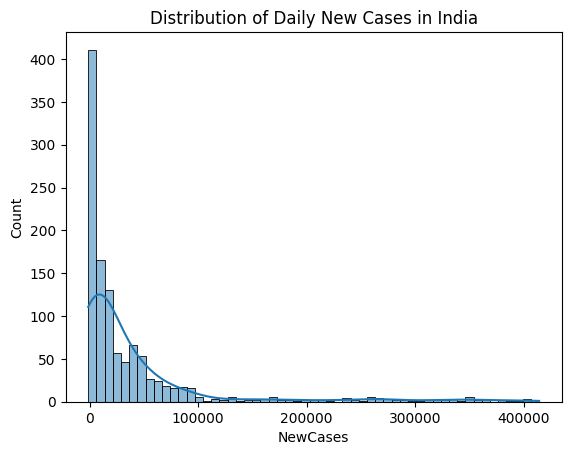

In [14]:
# Measures of spread
spread = covid.groupby('Location')['NewCases'].agg(['std'])
iqr = covid.groupby('Location')['NewCases'].quantile(0.75) - covid.groupby('Location')['NewCases'].quantile(0.25)
print("\nStd and IQR:\n", spread.join(iqr.rename('IQR')))

# Plot distributions for one country
sns.histplot(covid[covid['Location']=='India']['NewCases'], kde=True)
plt.title("Distribution of Daily New Cases in India")
plt.show()

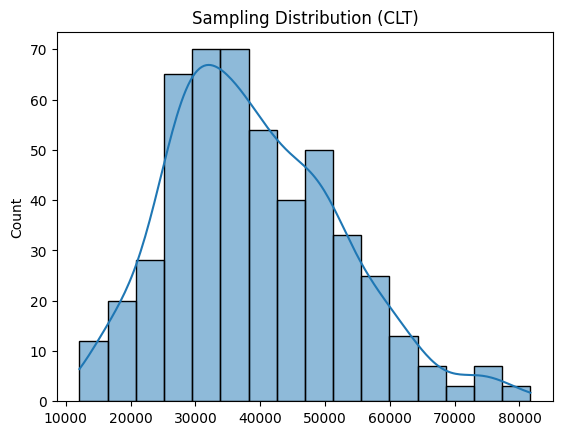

In [15]:
# CLT demonstration
samples = [covid[covid['Location']=='India']['NewCases'].sample(30).mean() for _ in range(500)]
sns.histplot(samples, kde=True)
plt.title("Sampling Distribution (CLT)")
plt.show()

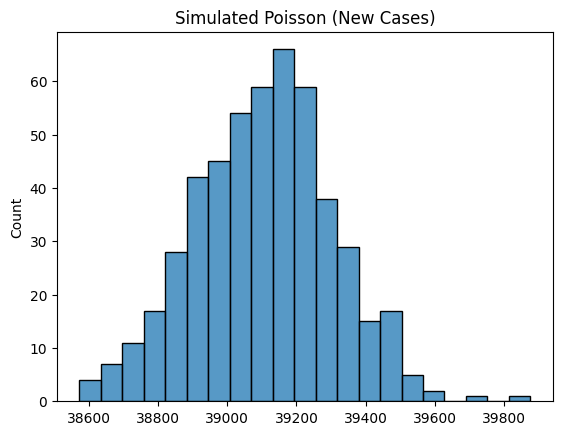

In [16]:
# Poisson model approximation
lam = covid[covid['Location']=='India']['NewCases'].mean()
pois = np.random.poisson(lam, size=500)
sns.histplot(pois, kde=False)
plt.title("Simulated Poisson (New Cases)")
plt.show()


Correlation:
            NewCases  NewDeaths
NewCases   1.000000   0.749452
NewDeaths  0.749452   1.000000


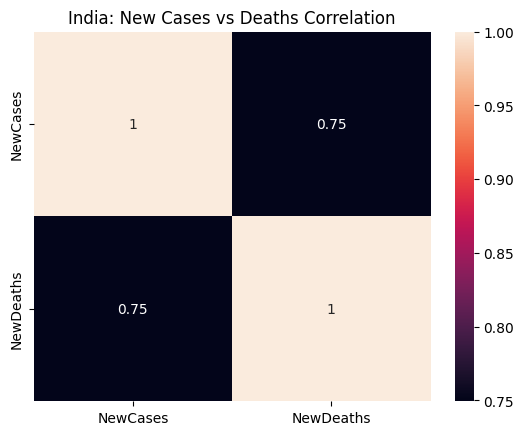

In [17]:

# Correlation between new cases/deaths for India
india = covid[covid['Location']=='India'][['NewCases', 'NewDeaths']]
print("\nCorrelation:\n", india.corr())
sns.heatmap(india.corr(), annot=True)
plt.title("India: New Cases vs Deaths Correlation")
plt.show()

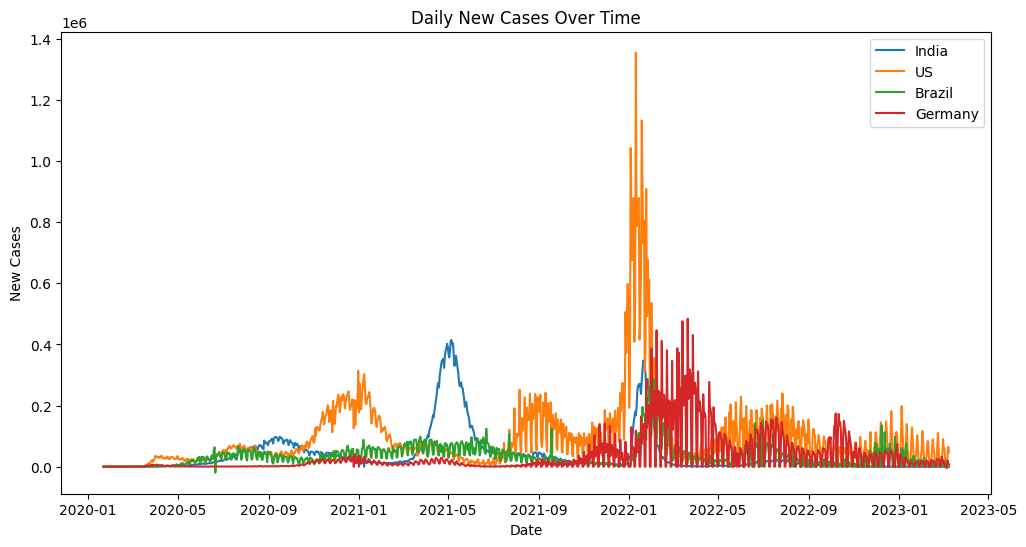

In [18]:


# Time series plot
plt.figure(figsize=(12,6))
for loc in countries:
    sub = covid[covid['Location']==loc]
    plt.plot(sub['Date'], sub['NewCases'], label=loc)
plt.legend()
plt.title("Daily New Cases Over Time")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.show()

In [19]:
# ✅ Real-World Use Case: Insight Extraction
print("\n📌 Why Analyze This Dataset?")
print("This COVID dataset helps identify outbreak patterns, assess healthcare impact, and optimize response policies across countries.")

print("\n📈 Key Insights:")
print("1. India's daily new cases peaked in specific periods, correlating with major waves.")
print("2. Positive correlation observed between new cases and deaths confirms healthcare pressure.")
print("3. High IQR in countries like Brazil suggests unpredictable spread rates.")

print("\n✅ Real-World Applications:")
print("- Government agencies can allocate oxygen beds and vaccine resources effectively using such data.")
print("- Public health teams can issue alerts when cases breach standard deviation thresholds.")
print("- Researchers can simulate spread using Poisson/Binomial models to plan interventions.")

# 🔖 Optional Export
# covid_filtered.to_csv('cleaned_covid_data.csv', index=False)


📌 Why Analyze This Dataset?
This COVID dataset helps identify outbreak patterns, assess healthcare impact, and optimize response policies across countries.

📈 Key Insights:
1. India's daily new cases peaked in specific periods, correlating with major waves.
2. Positive correlation observed between new cases and deaths confirms healthcare pressure.
3. High IQR in countries like Brazil suggests unpredictable spread rates.

✅ Real-World Applications:
- Government agencies can allocate oxygen beds and vaccine resources effectively using such data.
- Public health teams can issue alerts when cases breach standard deviation thresholds.
- Researchers can simulate spread using Poisson/Binomial models to plan interventions.
